In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi( # type: ignore
    model="qwen3-1.7b", # 这里用qwen3-0.6b似乎不支持structed_llm
    model_kwargs={
        "temperature": 0.0,
        "enable_thinking": False,
    },
)

In [3]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

编排器-工作节点工作流很常见，LangGraph 内置了对它们的支持。Send Send 允许您动态创建工作节点并向其发送特定的输入。每个工作节点都有自己的状态，所有工作节点的输出都会写入一个共享的状态键，编排器图可以访问该状态键。这使得编排器能够访问所有工作节点的输出，并将它们合成为最终输出。下面的示例遍历一个节列表，并使用 Send API 将节发送给每个工作节点。

In [4]:
from langgraph.types import Send

In [5]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [11]:
from langchain.messages import SystemMessage, HumanMessage
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]



In [12]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

In [13]:
# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)


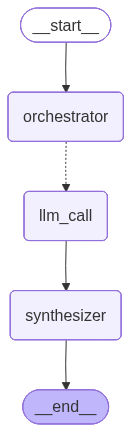

In [14]:
# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [16]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])


Large Language Models (LLMs) represent a significant advancement in artificial intelligence, enabling machines to understand, generate, and interact with human language in ways that were previously thought impossible. These models are trained on vast amounts of text data, allowing them to learn complex patterns, contextual relationships, and linguistic structures. By leveraging deep learning techniques, particularly transformer architectures, LLMs can produce coherent and contextually relevant responses, making them versatile tools for a wide range of applications.

The significance of LLMs in modern AI cannot be overstated. They have revolutionized natural language processing (NLP), enabling tasks such as machine translation, sentiment analysis, code generation, and content creation with unprecedented accuracy and efficiency. Moreover, LLMs have opened new possibilities for research and development in areas like conversational AI, personalized recommendations, and even creative writing. Their ability to adapt and learn from new data makes them highly valuable in both academic and industrial settings.

In summary, LLMs are not just a technological breakthrough but also a transformative force in the field of AI, reshaping how we interact with technology and expanding the boundaries of what is possible in natural language understanding and generation.

---

**Scaling Laws of LLMs**

The performance and efficiency of Large Language Models (LLMs) are governed by a set of scaling laws that describe how model size, training data, and other factors influence their capabilities. These laws provide a theoretical framework for understanding the relationship between model parameters, training data, and performance metrics such as accuracy, inference speed, and memory usage.

At the core of these scaling laws is the concept that increasing the number of parameters in an LLM generally leads to improved performance. This is often referred to as the "scaling law" in machine learning, where larger models tend to perform better on complex tasks due to increased capacity for learning and representation. However, this relationship is not linear and is influenced by several factors, including the quality of the training data, the architecture of the model, and the optimization techniques used during training.

One of the most well-known scaling laws is the **parameter count vs. performance** relationship, which suggests that as the number of parameters increases, the model's ability to capture complex patterns and generalize across tasks improves. This is typically observed in the early stages of training, where larger models outperform smaller ones in terms of accuracy and efficiency.

Another important aspect of scaling laws in LLMs is the **training data size**. The amount of data used to train an LLM has a direct impact on its performance. Larger datasets allow the model to learn more diverse and nuanced patterns, leading to better performance on a wide range of tasks. However, the benefits of increased data size diminish at some point, and there is a trade-off between data quantity and computational cost.

Additionally, **inference efficiency** is a critical factor in the scaling laws of LLMs. As models grow in size, they require more computational resources for inference, which can lead to longer response times and higher energy consumption. This highlights the need for efficient training and inference strategies, such as model pruning, quantization, and knowledge distillation, to maintain performance while reducing resource usage.

In summary, the scaling laws of LLMs reveal a complex interplay between model size, training data, and performance. Understanding these laws is essential for optimizing the design and deployment of large language models, ensuring they are both effective and efficient in real-world applications.

---

```markdown
# Technical Aspects of Scaling

The technical aspects of scaling Large Language Models (LLMs) involve a complex interplay of factors that determine the model's performance, efficiency, and scalability. Key considerations include:

- **Training Data**: The quality and quantity of training data significantly impact the model's ability to generalize and perform well across diverse tasks. Larger datasets can improve model accuracy but also increase computational demands and memory usage.

- **Model Size**: The size of the model directly affects its capacity to process information and generate coherent outputs. Larger models typically offer better performance but require more computational resources and energy.

- **Computational Resources**: Scaling LLMs necessitates substantial computational power, often involving high-performance computing (HPC) systems, distributed training, and efficient inference frameworks. The use of specialized hardware such as GPUs and TPUs is essential for handling the intensive calculations required during training and inference.

- **Optimization Techniques**: Techniques like quantization, pruning, and knowledge distillation are employed to reduce model size and computational requirements without compromising performance. These methods enable efficient deployment on resource-constrained devices while maintaining high-quality outputs.

- **Architecture Design**: The design of the model architecture plays a critical role in scalability. Modular and flexible architectures allow for easier adaptation and expansion, facilitating the integration of new features and the management of increasing data volumes.

- **Training Efficiency**: Efficient training processes, including parallelism, distributed training, and optimized algorithms, are crucial for scaling LLMs. These techniques help manage the vast amount of data and computational load, ensuring that training remains feasible and timely.

In summary, the technical aspects of scaling LLMs are multifaceted, requiring careful consideration of data, model structure, computational resources, and optimization strategies to achieve effective and sustainable growth.
```

---

Challenges and Limitations  
When scaling Large Language Models (LLMs), several challenges and limitations emerge, impacting both the feasibility and effectiveness of deployment. One of the primary issues is the **training cost**, which increases significantly as the model size grows. Training larger models requires more computational resources, extensive data, and longer training times, leading to higher costs and reduced efficiency. Additionally, the **inference speed** becomes a critical constraint, as larger models often require more time and computational power to process inputs, which can affect real-time applications and user experience.

Another significant limitation is **generalization**, where models may struggle to perform well on tasks outside their training domain. This is exacerbated by the fact that many LLMs are trained on diverse datasets, but they may not generalize effectively across different domains or tasks. Furthermore, **model bias** and **data quality** also play a role in limiting performance, as biased or incomplete data can lead to suboptimal outputs and ethical concerns.

These challenges highlight the need for ongoing research into efficient training techniques, optimized inference strategies, and improved generalization capabilities to make LLMs more scalable and practical for real-world applications.

---

**Future Directions in Scaling**

The future of Large Language Models (LLMs) lies in continuous innovation and refinement of scaling strategies. As models grow in size and complexity, the need for more efficient architectures, optimized training processes, and scalable deployment frameworks becomes increasingly critical. Emerging research is exploring new ways to enhance model performance while maintaining computational efficiency and reducing resource consumption.

One promising direction is the development of more efficient neural network architectures that can achieve higher performance with fewer parameters. This includes innovations such as knowledge distillation, where smaller models are trained to mimic the behavior of larger ones, or the use of novel attention mechanisms that improve both throughput and accuracy. Additionally, there is growing interest in hybrid models that combine different types of architectures to leverage their respective strengths.

Optimization techniques are also evolving to address the challenges of large-scale training and inference. Techniques such as quantization, pruning, and knowledge-based optimization are being refined to reduce memory usage and accelerate computation without sacrificing model quality. Furthermore, distributed training approaches are becoming more sophisticated, enabling models to be trained across multiple devices and even across different cloud environments.

In terms of deployment, the focus is shifting towards more flexible and scalable solutions that can adapt to varying computational resources and user needs. This includes the development of lightweight models suitable for edge devices, as well as advanced techniques for model serving and real-time inference.

Ultimately, the future of LLM scaling will depend on a combination of architectural innovation, optimization advancements, and practical deployment strategies that ensure models remain both powerful and accessible.